<u><h1>CNN Training Phase</h1></u>

<i><b>Note that to check about how I came through for the below model, please checkout the file CNN Improvisation (Choosing the best architecture).ipynb for more in-detail step-by-step clarification.</b></i>

In [1]:
import cv2
import os
import numpy as np
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
data = np.load("numpy-data/data.npy")
target = np.load("numpy-data/target.npy")

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data,
    target,
    test_size=0.2
)

In [4]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=data.shape[1:], padding="same", kernel_initializer="orthogonal"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

model.add(Conv2D(16, (3, 3), kernel_initializer="orthogonal", padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), kernel_initializer="orthogonal", padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(7, 7)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(2, activation="softmax"))
          
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        4

In [10]:
val_loss_checkpoint_callback = ModelCheckpoint(
    filepath="best_val_loss_models/val_loss_model.{epoch:03d}-{loss:.4f}-{val_loss:.4f}.h5",
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

val_acc_checkpoint_callback = ModelCheckpoint(
    filepath="best_val_acc_models/val_acc_model.{epoch:03d}-{loss:.4f}-{val_accuracy:.4f}.h5",
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True
)

In [11]:
img_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode="wrap",
)
img_generator.fit(train_data)

In [8]:
train_batch_size = 20

history = model.fit(
    img_generator.flow(train_data, train_labels, shuffle=True, batch_size=train_batch_size),
    validation_data=(test_data, test_labels),
    epochs=100,
    steps_per_epoch=len(train_data) // train_batch_size,
    callbacks=[val_loss_checkpoint_callback, val_acc_checkpoint_callback]
)

Epoch 1/100
997/997 [==============================] - 159s 120ms/step - loss: 0.6860 - accuracy: 0.5584 - val_loss: 0.5809 - val_accuracy: 0.7050
Epoch 2/100
997/997 [==============================] - 119s 119ms/step - loss: 0.6083 - accuracy: 0.6719 - val_loss: 0.5414 - val_accuracy: 0.7455
Epoch 3/100
997/997 [==============================] - 111s 112ms/step - loss: 0.5854 - accuracy: 0.6917 - val_loss: 0.5195 - val_accuracy: 0.7387
Epoch 4/100
997/997 [==============================] - 120s 121ms/step - loss: 0.5681 - accuracy: 0.7023 - val_loss: 0.4823 - val_accuracy: 0.7653
Epoch 5/100
997/997 [==============================] - 113s 113ms/step - loss: 0.5553 - accuracy: 0.7146 - val_loss: 0.4869 - val_accuracy: 0.7623
Epoch 6/100
997/997 [==============================] - 112s 113ms/step - loss: 0.5560 - accuracy: 0.7138 - val_loss: 0.4648 - val_accuracy: 0.7824
Epoch 7/100
997/997 [==============================] - 113s 114ms/step - loss: 0.5363 - accuracy: 0.7311 - val_loss: 0

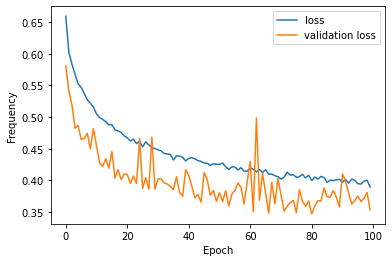

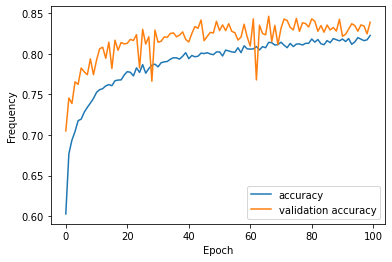

In [9]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Frequency")
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Frequency")
plt.show()

In [42]:
# model.load_weights("best_val_loss_models/val_loss_model.081-0.3996-0.3468.h5")
model.load_weights("model/val_loss_model.081-0.3996-0.3468.h5")

In [43]:
loss, acc = model.evaluate(test_data, test_labels)
print(loss, acc)

156/156 [==============================] - 5s 25ms/step - loss: 0.3476 - accuracy: 0.8420
0.34682080149650574 0.8428857922554016


In [33]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

In [34]:
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)

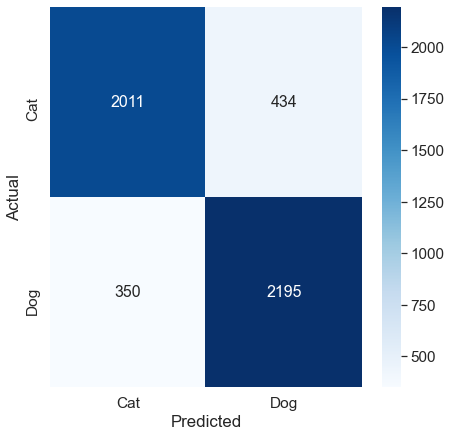

In [35]:
df_cm = pd.DataFrame(confusion, columns=np.unique(["Cat", "Dog"]), index = np.unique(["Cat", "Dog"]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7, 7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")

In [36]:
print("Prediction accuracy for class Dog: ", (confusion[0][0] / np.sum(confusion[0])) * 100)
print("Prediction accuracy for class Cat: ", (confusion[1][1] / np.sum(confusion[1])) * 100)
print("Overall accuracy: ", ((confusion[0][0] + confusion[1][1]) / (np.sum(confusion))) * 100)

Prediction accuracy for class Dog:  82.24948875255623
Prediction accuracy for class Cat:  86.2475442043222
Overall accuracy:  84.28857715430863


In [37]:
test_img_root = "test"
img_files = os.listdir(test_img_root)
labels = {0: "Cat", 1: "Dog"}

In [38]:
images = []
orig_images = []

for img_file in img_files:
    img_path = os.path.join(test_img_root, img_file)
    orig_image = cv2.imread(img_path)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (50, 50))
    
    orig_images.append(cv2.resize(orig_image, (100, 100)))
    images.append(image)
    
images = np.asarray(images)
orig_images = np.asarray(orig_images)

In [39]:
predictions = []

for image in images:
    image = image / 255
    image = np.reshape(image, (1, 50, 50, 1))
    prediction = model.predict(image)
    arg_max = np.argmax(prediction, axis=1)[0]
    label = labels[arg_max]
    predictions.append((label, prediction[0][arg_max]))

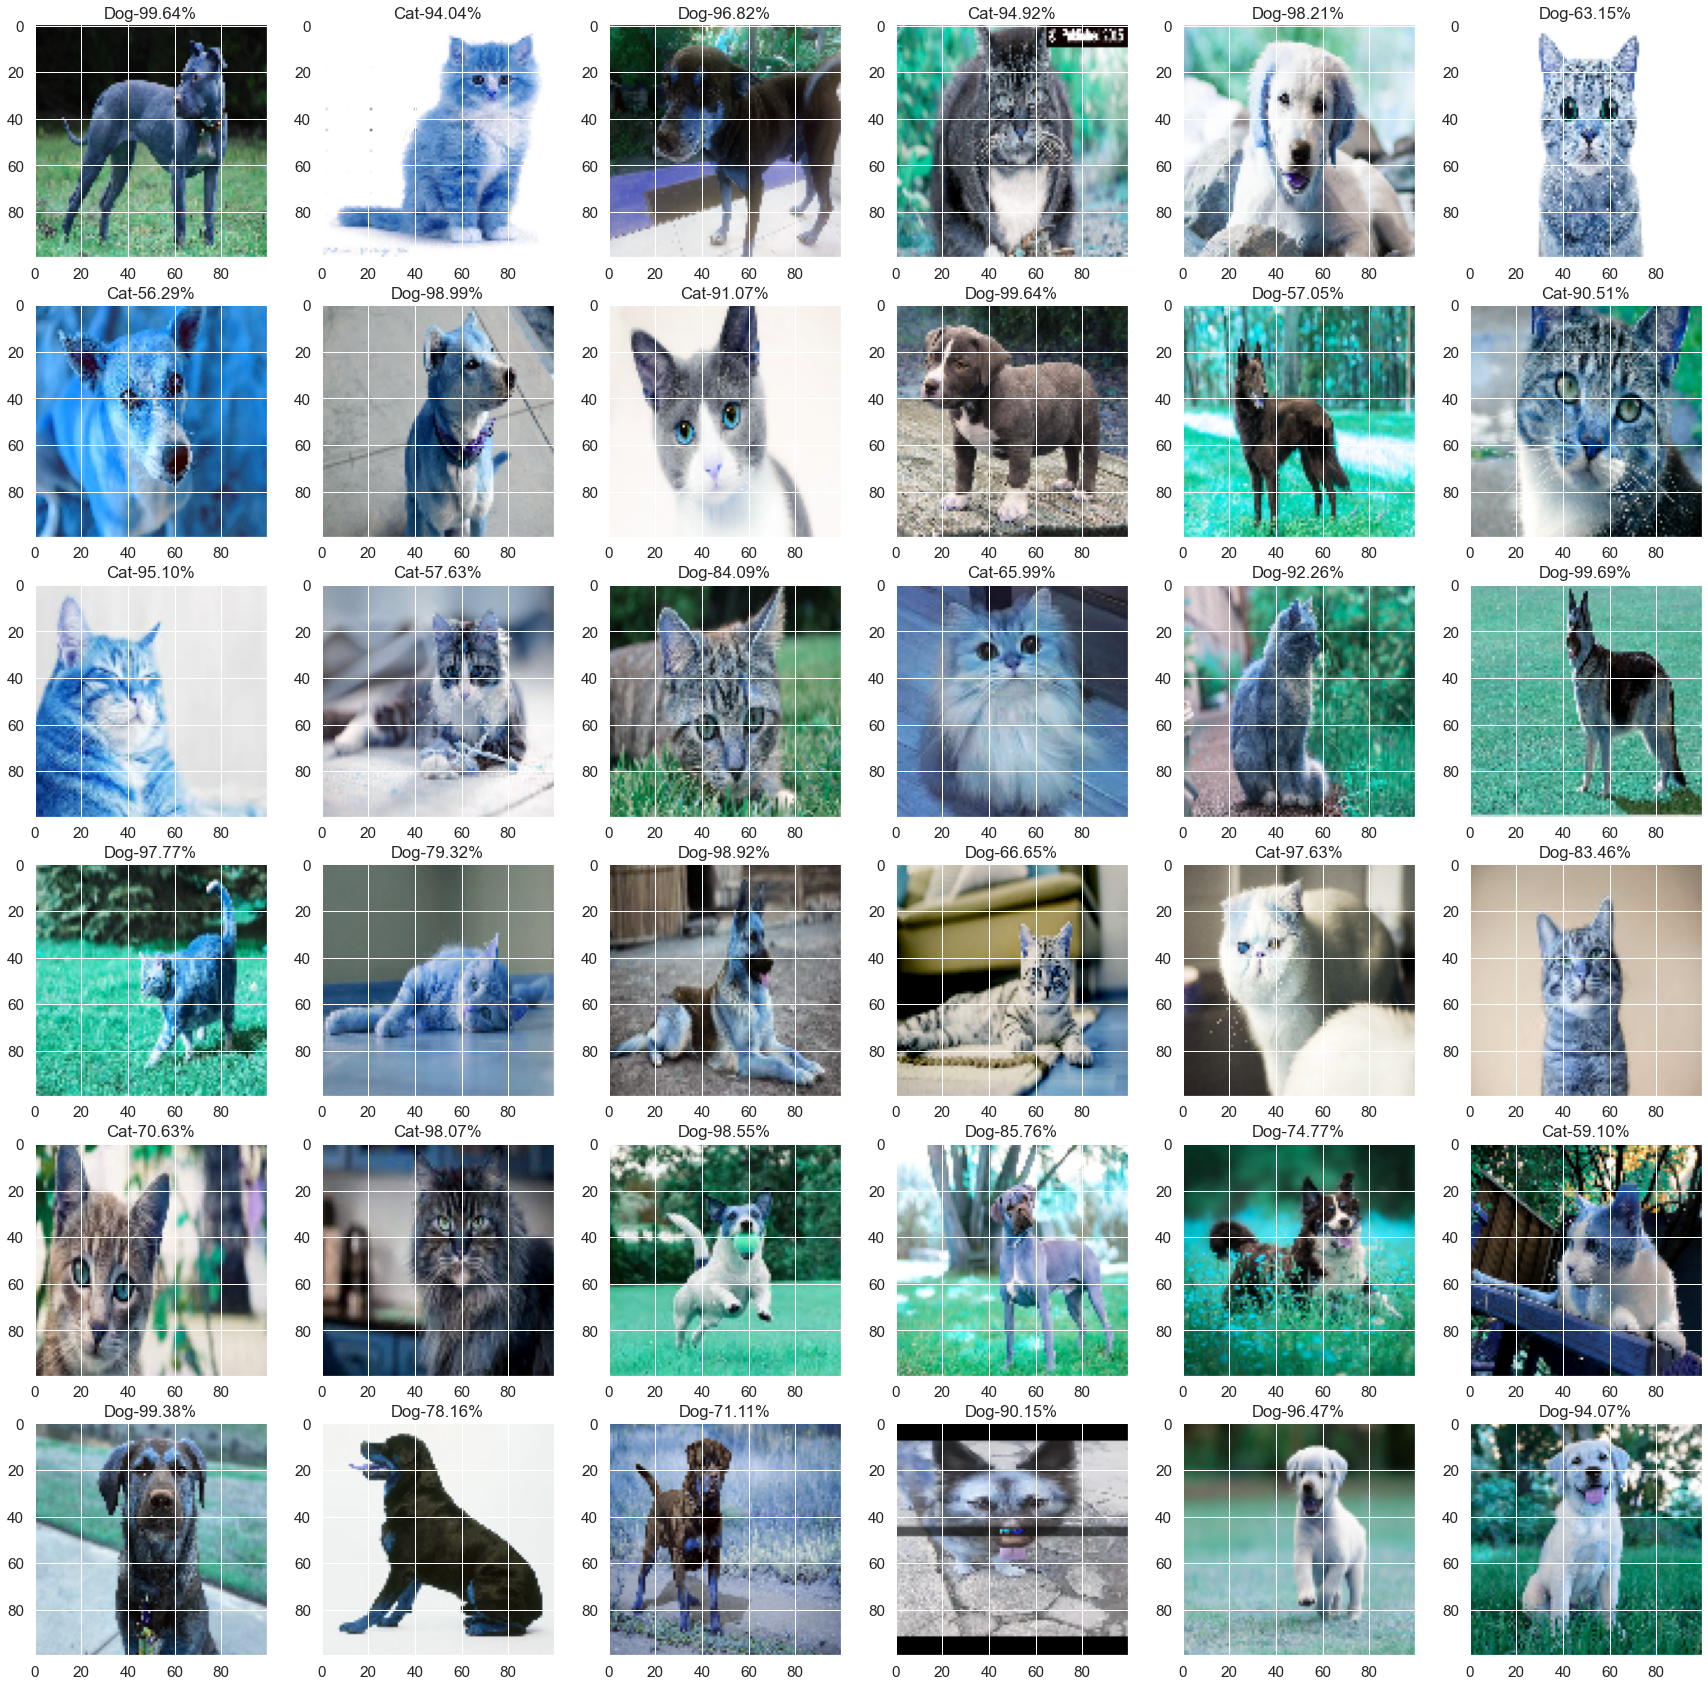

In [40]:
figure = plt.figure(figsize=(30, 30))
cols = 6
rows = 6

for i in range(cols * rows):
    image = orig_images[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(predictions[i][0] + "-" + "{0:.2f}%".format(predictions[i][1] * 100))
    plt.imshow(image)
plt.show()

<hr>

In [15]:
model.load_weights("best_val_loss_models/val_loss_model.048-0.3876-0.3249.h5")

In [16]:
loss, acc = model.evaluate(test_data, test_labels)
print(loss, acc)

156/156 [==============================] - 4s 25ms/step - loss: 0.3249 - accuracy: 0.8493
0.3249469995498657 0.8492985963821411


In [18]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

In [19]:
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)

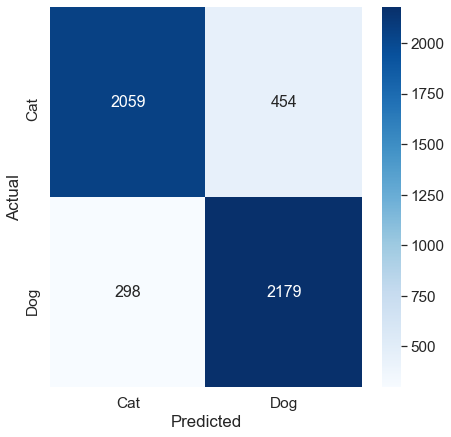

In [20]:
df_cm = pd.DataFrame(confusion, columns=np.unique(["Cat", "Dog"]), index = np.unique(["Cat", "Dog"]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7, 7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")

In [21]:
print("Prediction accuracy for class Dog: ", (confusion[0][0] / np.sum(confusion[0])) * 100)
print("Prediction accuracy for class Cat: ", (confusion[1][1] / np.sum(confusion[1])) * 100)
print("Overall accuracy: ", ((confusion[0][0] + confusion[1][1]) / (np.sum(confusion))) * 100)

Prediction accuracy for class Dog:  81.93394349383207
Prediction accuracy for class Cat:  87.96931772305207
Overall accuracy:  84.92985971943888


In [23]:
test_img_root = "test"
img_files = os.listdir(test_img_root)
labels = {0: "Cat", 1: "Dog"}

In [24]:
images = []
orig_images = []

for img_file in img_files:
    img_path = os.path.join(test_img_root, img_file)
    orig_image = cv2.imread(img_path)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (50, 50))
    
    orig_images.append(cv2.resize(orig_image, (100, 100)))
    images.append(image)
    
images = np.asarray(images)
orig_images = np.asarray(orig_images)

In [25]:
predictions = []

for image in images:
    image = image / 255
    image = np.reshape(image, (1, 50, 50, 1))
    prediction = model.predict(image)
    arg_max = np.argmax(prediction, axis=1)[0]
    label = labels[arg_max]
    predictions.append((label, prediction[0][arg_max]))

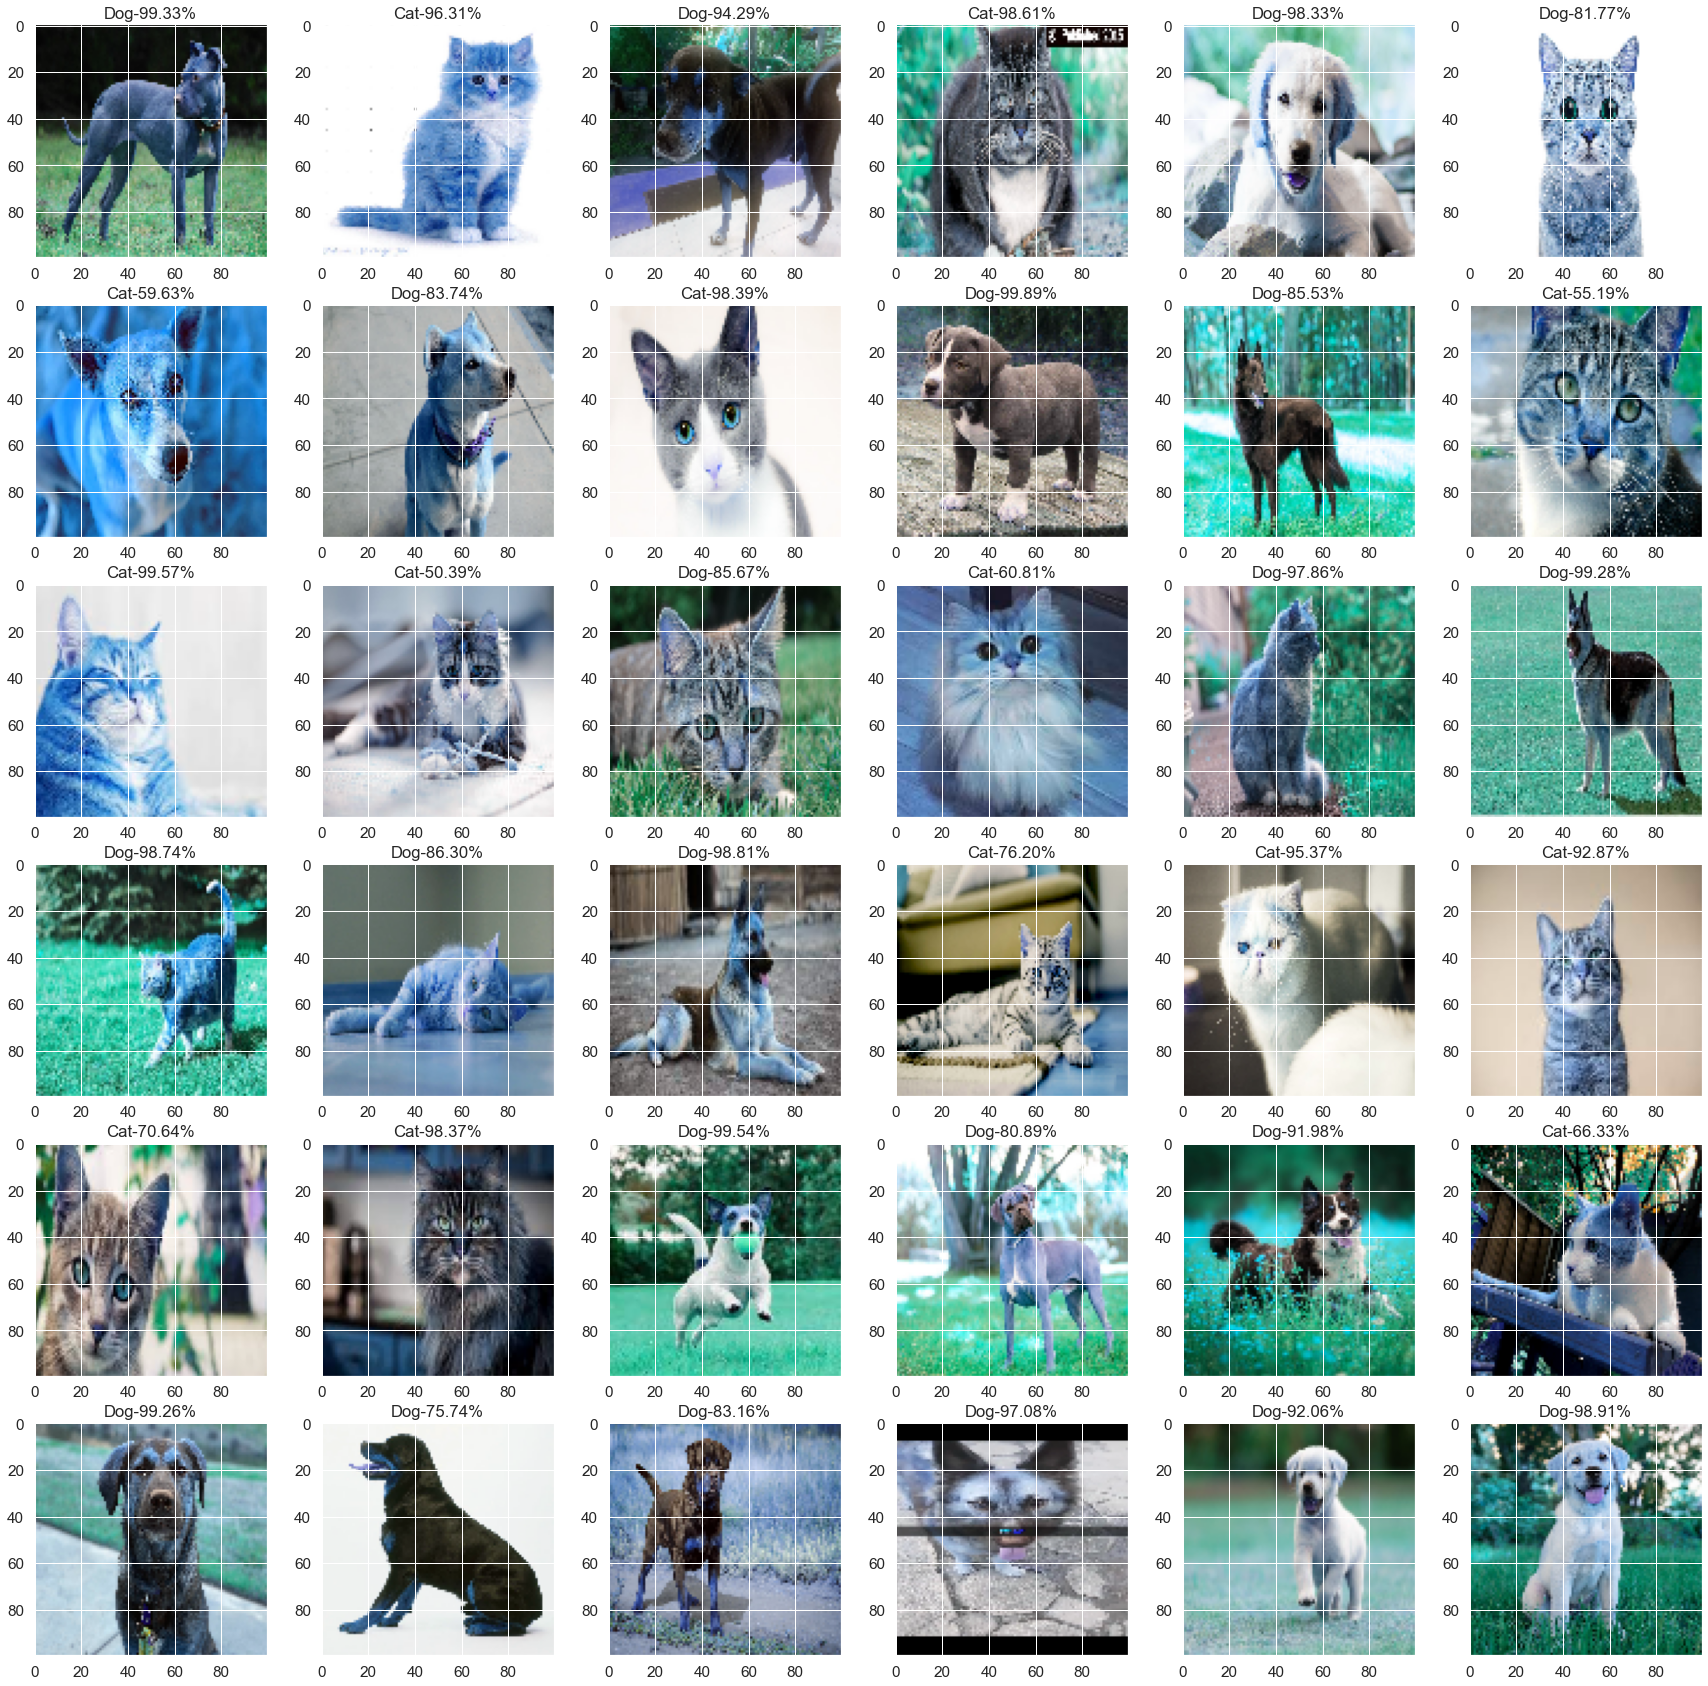

In [26]:
figure = plt.figure(figsize=(30, 30))
cols = 6
rows = 6

for i in range(cols * rows):
    image = orig_images[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(predictions[i][0] + "-" + "{0:.2f}%".format(predictions[i][1] * 100))
    plt.imshow(image)
plt.show()

<hr>
<p><b>Done by: </b>B.K.Sineth Sankalpa</p>